In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

get_ipython().run_line_magic('matplotlib', 'inline')

# read in overall dataframe
movie_df = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df.csv") 

# read in dataframes separated by year
movie_df_1940_2020 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_1940_2020.csv") 
movie_df_1940_1960_n75 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_1940_1960_n75.csv")
movie_df_1960_1980 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_1960_1980.csv")
movie_df_1980_2000 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_1980_2000.csv")
movie_df_2000_2020 = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/dataframes/movie_df_2000_2020.csv")

movie_df_1940_1960_n75.head()

,Unnamed: 0,Movie Name,Genre,Year,Country,Text,Tokenized Texts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,tokenized_sents,normalized_sents,tokenized_words,normalized_words
0,3097579,Charlie Chan at the Opera,"Comedy, Mystery, Thriller",1936,English,@@3097579 [Man_Singing_In_Italian] [Thunder_Ru...,"['Man_Singing_In_Italian', 'Thunder_Rumbling',...","['man_singing_in_italian', 'thunder_rumble', '...",2637,"[('@@3097579', 'JJ'), ('[', '-LRB-'), ('man_si...","[['@@3097579', 'Man_Singing_In_Italian'], ['Th...","[['@@3097579', 'man_singing_in_italian'], ['th...","['@@3097579', 'Man_Singing_In_Italian', 'Thund...","['@@3097579', 'man_singing_in_italian', 'thund..."
1,3274436,Lady Killer,"Comedy, Crime",1933,"English, Yiddish","@@3274436 - Count off . USHERS : One , two , t...","['Count', 'off', 'USHERS', 'One', 'two', 'thre...","['count', 'usher', 'ease', 'man', 'mr', 'jeffr...",3288,"[('@@3274436', 'LS'), ('-', ':'), ('count', 'V...","[['@@3274436', 'Count', 'off'], ['USHERS'], ['...","[['@@3274436', 'count'], ['usher'], [], [], []...","['@@3274436', 'Count', 'off', 'USHERS', 'One',...","['@@3274436', 'count', 'ushers', 'ease', 'men'..."
2,3589306,Between Two Worlds,"Mystery, Drama, Fantasy",1944,English,@@3589306 YOUR ATTENTION . BUSES AND CARS ARE ...,"['YOUR', 'ATTENTION', 'BUSES', 'AND', 'CARS', ...","['attention', 'bus', 'car', 'draw', 'ship', 'r...",620,"[('@@3589306', 'VB'), ('your', 'PRP$'), ('atte...","[['@@3589306'], ['YOUR', 'ATTENTION'], ['BUSES...","[['@@3589306'], ['attention'], ['bus', 'car', ...","['@@3589306', 'YOUR', 'ATTENTION', 'BUSES', 'A...","['@@3589306', 'attention', 'buses', 'cars', 'd..."
3,3097414,Charlie Chan at the Circus,"Comedy, Crime, Mystery",1936,English,"@@3097414 [Barker] Ladies and gentlemen , the ...","['Barker', 'Ladies', 'and', 'gentlemen', 'the'...","['barker', 'lady', 'gentleman', 'big', 'aggreg...",3325,"[('@@3097414', 'DT'), ('[', '-LRB-'), ('barker...","[['@@3097414'], ['Barker', 'Ladies', 'and', 'g...","[['@@3097414'], ['barker', 'lady', 'gentleman'...","['@@3097414', 'Barker', 'Ladies', 'and', 'gent...","['@@3097414', 'barker', 'ladies', 'gentlemen',..."
4,6850720,Animal Crackers,"Comedy, Musical",1930,English,@@6850720 You must do your best tonight Be on ...,"['You', 'must', 'do', 'your', 'best', 'tonight...","['good', 'tonight', 'toe', 'man', 'guest', 'to...",4868,"[('@@6850720', 'IN'), ('you', 'PRP'), ('must',...","[['@@6850720', 'You', 'must', 'do', 'your', 'b...","[['@@6850720', 'well', 'tonight'], ['toe', 'ma...","['@@6850720', 'You', 'must', 'do', 'your', 'be...","['@@6850720', 'best', 'tonight', 'toes', 'men'..."


In [2]:
# tokenize and normalize text
movie_df_1940_1960_n75['tokenized_sents'] = movie_df_1940_1960_n75['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movie_df_1940_1960_n75['normalized_sents'] = movie_df_1940_1960_n75['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [3]:
# define cooccurrence function
# words that co-occur in the same sentences
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

g_1940_1960 = wordCooccurrence(movie_df_1940_1960_n75['normalized_sents'][:100].sum())

In [4]:
# length of nodes
len(g_1940_1960.nodes)

13622

In [5]:
# length of edges
len(g_1940_1960.edges)

201180

In [6]:
# adjacency matrix of cleaned word by scripts
nx.to_numpy_matrix(g_1940_1960)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

import sklearn.feature_extraction
# in case we get a module not found error

In [8]:
movieVectorizer_1940_1960 = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
movieVects_1940_1960_incidence = movieVectorizer_1940_1960.fit_transform(movie_df_1940_1960_n75['Text'][:100])

movieVects_1940_1960_incidence.shape

(75, 13602)

In [9]:
# need to turn the incidence matrix into a network
g_2mode_1940_1960 = nx.Graph()

In [10]:
#define all the nodes
g_2mode_1940_1960.add_nodes_from((movieVectorizer_1940_1960.get_feature_names()[i] for i in range(movieVects_1940_1960_incidence.shape[1])), bipartite = 'word')
g_2mode_1940_1960.add_nodes_from(range(movieVects_1940_1960_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_1940_1960.add_edges_from(((d, movieVectorizer_1940_1960.get_feature_names()[w], {'weight' : movieVects_1940_1960_incidence[d, w]}) for d, w in zip(*movieVects_1940_1960_incidence.nonzero())))

In [11]:
print(nx.info(g_2mode_1940_1960))

Name: 
Type: Graph
Number of nodes: 13677
Number of edges: 67608
Average degree:   9.8864


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


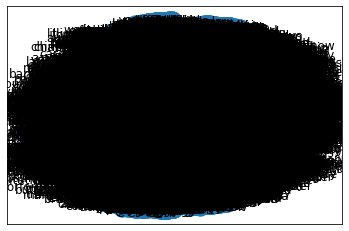

In [12]:
# plot the bipartite network with a quick spring layout
# with no filtering, this will not bring insight 
nx.draw_networkx(g_2mode_1940_1960)

In [13]:
# two-mode network can be easily transformed into two one-mode network, enabling words to be 
# connected to other words via the number of documents that share them, 
# or documents to be connected to other documents via the words they share
def contractNetwork(g_1940_1960, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode_1940_1960.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode_1940_1960.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g_1940_1960.neighbors(n_outside) if g_1940_1960.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [14]:
# document-to-document network:
gDoc_1940_1960 = contractNetwork(g_2mode_1940_1960, 'doc')
print(nx.info(gDoc_1940_1960))

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 2775
Average degree:  74.0000


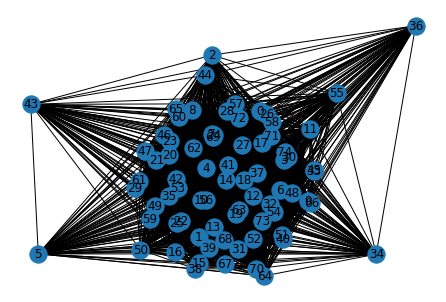

In [15]:
# visualize doc to doc
layout = nx.spring_layout(gDoc_1940_1960, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_1940_1960, pos = layout, labels = {n:n for n in gDoc_1940_1960.nodes()}) #Getting labels is a bit annoying

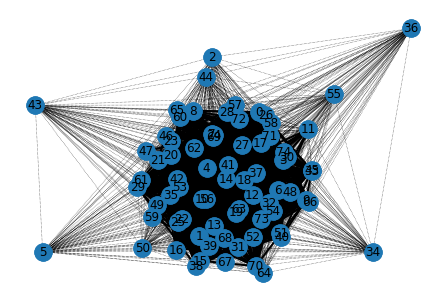

In [16]:
# draw the graph with high and low weight edges distinguished:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc_1940_1960.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc_1940_1960.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc_1940_1960.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc_1940_1960, pos = layout, labels = {n:n for n in gDoc_1940_1960.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc_1940_1960, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [17]:
# word-to-word network by documents
gWord_1940_1960 = contractNetwork(g_2mode_1940_1960, 'word')
print(nx.info(gWord_1940_1960))

Name: 
Type: Graph
Number of nodes: 13602
Number of edges: 16016403
Average degree: 2355.0071


In [18]:
# reduce the number of words to a manageable size.
wMean_1940_1960 = np.mean([d['weight'] for n1, n2, d in gWord_1940_1960.edges(data = True)])
wMean_1940_1960

2.1398359544274705

In [19]:
g_1940_1960 = wordCooccurrence(movie_df_1940_1960_n75['normalized_sents'][:100].sum())

In [20]:
len(g_1940_1960)

13622

In [21]:
g_1940_1960.remove_edges_from([(n1, n2) for n1, n2, d in g_1940_1960.edges(data = True) if d['weight'] <= 25])

In [22]:
g_1940_1960.remove_nodes_from(list(nx.isolates(g_1940_1960))) #since we are changing the graph list() evaluates the isolates first

In [23]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

giant_1940_1960 = max(connected_component_subgraphs(g_1940_1960), key=len) # keep just the giant connected component
print(nx.info(giant_1940_1960))

Name: 
Type: Graph
Number of nodes: 121
Number of edges: 364
Average degree:   6.0165


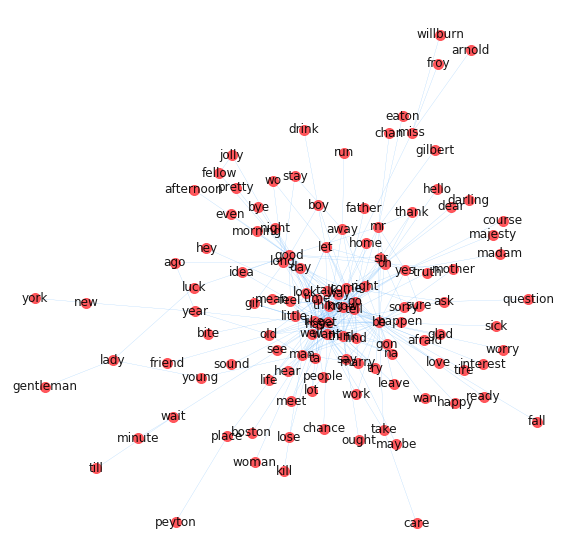

In [24]:
# graph this smaller version
layout = nx.spring_layout(giant_1940_1960, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [25]:
from networkx.algorithms.community import greedy_modularity_communities
c_1940_1960 = list(greedy_modularity_communities(giant_1940_1960))

In [26]:
# finding communities in graphs
c_1940_1960

[frozenset({'afraid',
            'afternoon',
            'ago',
            'arnold',
            'ask',
            'away',
            'be',
            'bite',
            'boston',
            'boy',
            'bye',
            'care',
            'chan',
            'chance',
            'come',
            'course',
            'darling',
            'day',
            'dear',
            'drink',
            'eaton',
            'even',
            'fall',
            'father',
            'feel',
            'fellow',
            'find',
            'friend',
            'froy',
            'gentleman',
            'get',
            'gilbert',
            'girl',
            'glad',
            'go',
            'gon',
            'good',
            'happen',
            'happy',
            'have',
            'hear',
            'hello',
            'hey',
            'home',
            'idea',
            'interest',
            'jolly',
            'kill',
         

In [27]:
# can also remove those words that show up in many documents
giant_1940_1960 = nx.Graph(giant_1940_1960)

In [28]:
giant_1940_1960.remove_nodes_from([n for n in giant_1940_1960.nodes if len(set(giant_1940_1960.neighbors(n))) >= 2000]) 
giant_1940_1960.remove_nodes_from(list(nx.isolates(giant_1940_1960)))
print(nx.info(giant_1940_1960))

Name: 
Type: Graph
Number of nodes: 121
Number of edges: 364
Average degree:   6.0165


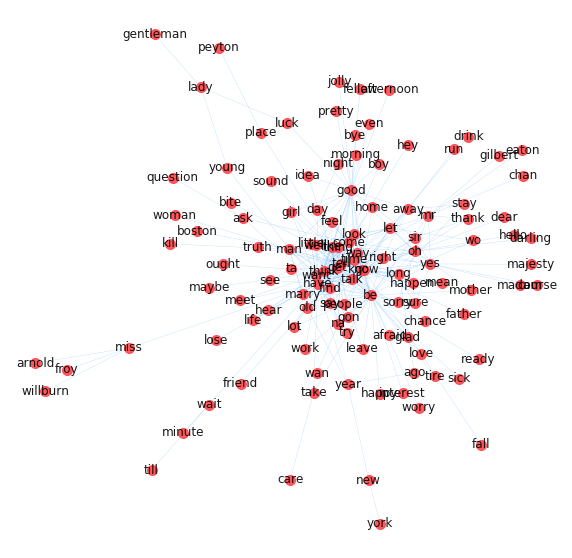

In [29]:
layout = nx.spring_layout(giant_1940_1960, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [30]:
# find cliques, or completely connected sets of nodes.
print(', '.join(max(nx.clique.find_cliques(giant_1940_1960), key = lambda x: len(x))))

be, have, know, like, think, get, want, tell, come, man


In [31]:
# look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'afraid'.
gunNeighbors = giant_1940_1960.neighbors('afraid')
g_gun = giant_1940_1960.subgraph(gunNeighbors)

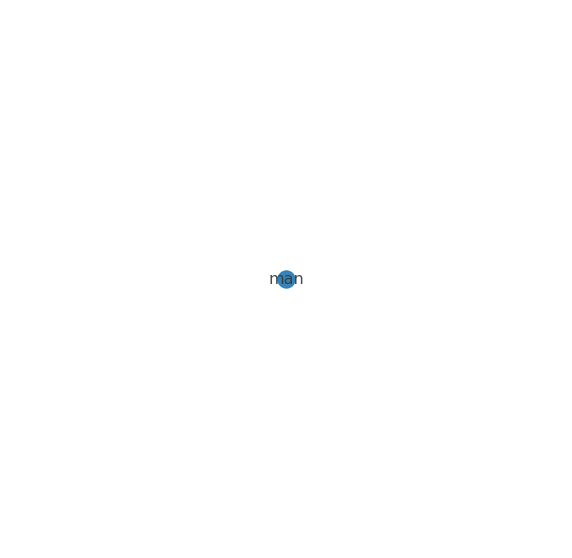

In [44]:
layout_gun = nx.spring_layout(g_gun, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
nx.draw(g_gun, ax = ax, pos = layout_gun, labels = {n:n for n in g_gun.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gun.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

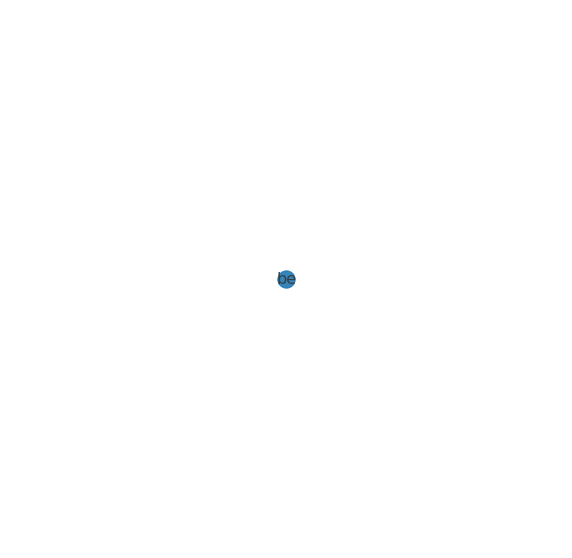

In [32]:
layout_gun = nx.spring_layout(g_gun, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gun.edges(data = True)))
nx.draw(g_gun, ax = ax, pos = layout_gun, labels = {n:n for n in g_gun.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gun.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [33]:
gunNeighbors = gWord_1940_1960.neighbors('afraid')
gunNeighborsPlus1 = set(gunNeighbors)
for n in gunNeighbors:
    gunNeighborsPlus1 |= set(giant_1940_1960.neighbors(n))

In [34]:
g_gun2 = giant_1940_1960.subgraph(gunNeighborsPlus1)
print(nx.info(g_gun2))

Name: 
Type: Graph
Number of nodes: 120
Number of edges: 363
Average degree:   6.0500


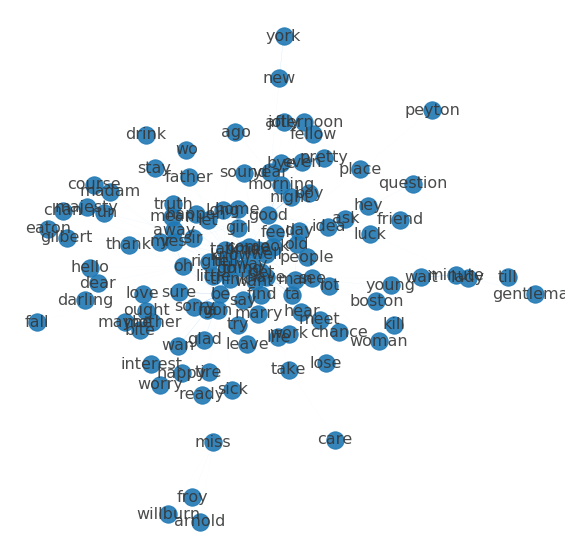

In [35]:
layout_gun = nx.spring_layout(g_gun2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_gun = nx.eigenvector_centrality(g_gun2)
maxC = max(centralities_gun.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_gun2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gun2.edges(data = True)))
nx.draw(g_gun2, ax = ax, pos = layout_gun, labels = {n:n for n in g_gun2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gun2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [36]:
# can often gain more insight into our semantic network through statistics that describe the positions of words within it.
dcentralities_1940_1960 = nx.degree_centrality(giant_1940_1960)

In [51]:
dcentralities_1940_1960['afraid']

0.008333333333333333

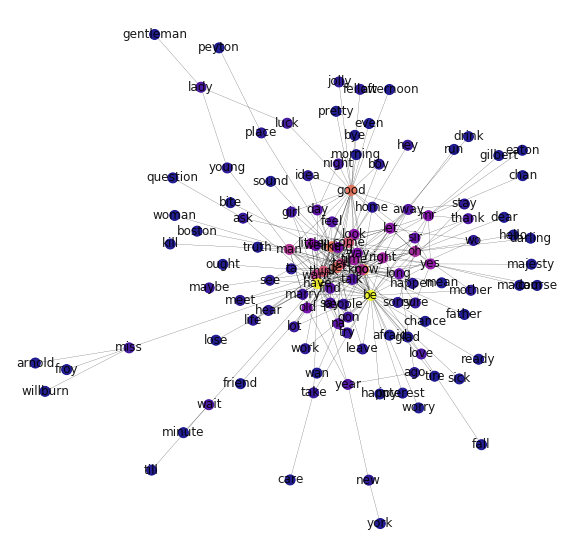

In [52]:
# We can color and size the nodes by betweenness centrality,
max(dcentralities_1940_1960.items(), key = lambda x : x[1])

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_1940_1960.items(), key = lambda x : x[1])[1]
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_1940_1960[n] / maxC for n in giant_1940_1960.nodes],
        cmap = plt.get_cmap('plasma'))

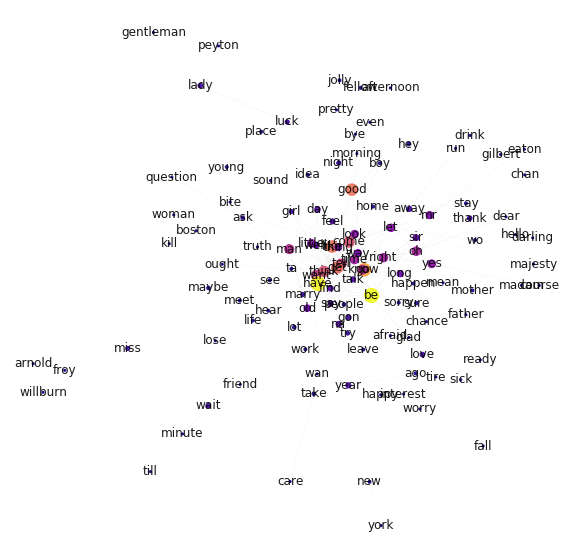

In [53]:
# use of size to represent degree centrality and edge weight:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities_1940_1960.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_1940_1960.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities_1940_1960[n] / maxC for n in giant_1940_1960.nodes],
        node_size = [dcentralities_1940_1960[n] / maxC * 200 for n in giant_1940_1960.nodes],
        cmap = plt.get_cmap('plasma'))

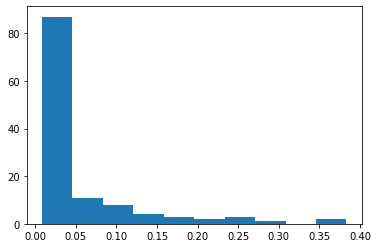

In [54]:
# The distrubution of degree centrality is:
plt.hist(list(dcentralities_1940_1960.values()))
plt.show()

In [55]:
# top words by degree
sorted(dcentralities_1940_1960.items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.3833333333333333),
 ('have', 0.375),
 ('know', 0.3),
 ('like', 0.25),
 ('good', 0.25),
 ('get', 0.24166666666666667),
 ('come', 0.20833333333333334),
 ('think', 0.20833333333333334),
 ('tell', 0.18333333333333332),
 ('want', 0.175)]

In [56]:
# different measure, which is betweenness centrality. 
# Betweenness centrality distinguishes nodes that require the most shortest pathways between
# all other nodes in the network. Semantically, words with a high betweenness centrality may link 
# distinctive domains, rather than being "central" to any one. 
# In other words, high betweenness centrality nodes may not have the highest degree centrality.
centralities_1940_1960 = nx.betweenness.betweenness_centrality(giant_1940_1960)
centralities_1940_1960['afraid']

0.0

In [57]:
max(centralities_1940_1960.items(), key = lambda x : x[1])

('have', 0.3024607307709473)

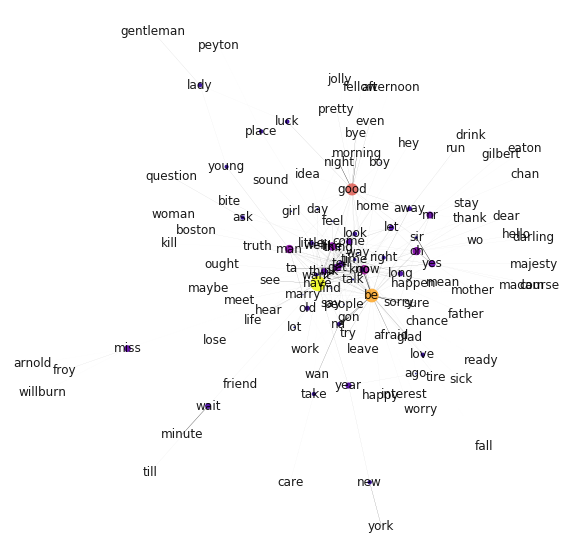

In [58]:
# color and size the nodes by betweenness centrality:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_1940_1960.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_1940_1960.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_1940_1960[n] / maxC for n in giant_1940_1960.nodes],
        node_size = [centralities_1940_1960[n] / maxC * 200 for n in giant_1940_1960.nodes],
        cmap = plt.get_cmap('plasma'))

In [59]:
# What are the top ten words in terms of betweenness? 
sorted(dcentralities_1940_1960.items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.3833333333333333),
 ('have', 0.375),
 ('know', 0.3),
 ('like', 0.25),
 ('good', 0.25),
 ('get', 0.24166666666666667),
 ('come', 0.20833333333333334),
 ('think', 0.20833333333333334),
 ('tell', 0.18333333333333332),
 ('want', 0.175)]

In [60]:
# closeness centrality, or the average Euclidean or path distance between a node and all others in the network.
# A node with the highest closeness centrality is most likely to send a signal with the most coverage to the 
# rest of the network.
centralities_1940_1960 = nx.closeness_centrality(giant_1940_1960)

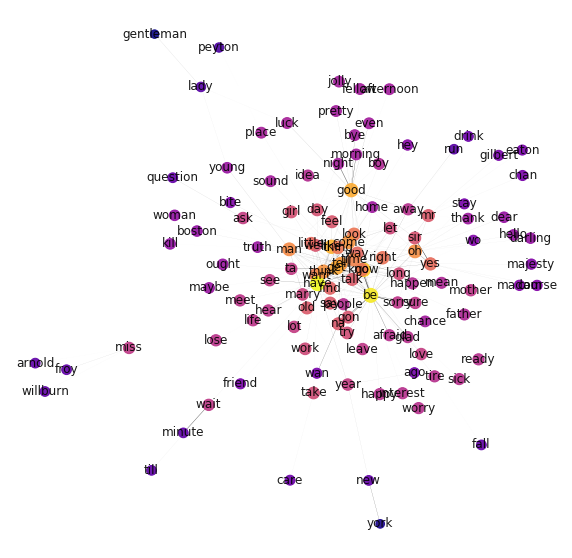

In [61]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_1940_1960.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_1940_1960.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_1940_1960[n] / maxC for n in giant_1940_1960.nodes],
        node_size = [centralities_1940_1960[n] / maxC * 200 for n in giant_1940_1960.nodes],
        cmap = plt.get_cmap('plasma'))

In [62]:
# Top:
sorted(centralities_1940_1960.items(), key = lambda x: x[1], reverse = True)[:10]

[('have', 0.5741626794258373),
 ('be', 0.5607476635514018),
 ('know', 0.5357142857142857),
 ('like', 0.5106382978723404),
 ('good', 0.5063291139240507),
 ('get', 0.5042016806722689),
 ('tell', 0.48582995951417),
 ('come', 0.4838709677419355),
 ('think', 0.4819277108433735),
 ('oh', 0.47619047619047616)]

In [63]:
# Or eignvector centrality, an approach that weights degree by the centrality of those to whom 
# one is tied (and the degree to whom they are tied, etc.) 
# In short, its an $n$th order degree measure.
centralities_1940_1960 = nx.eigenvector_centrality(giant_1940_1960)

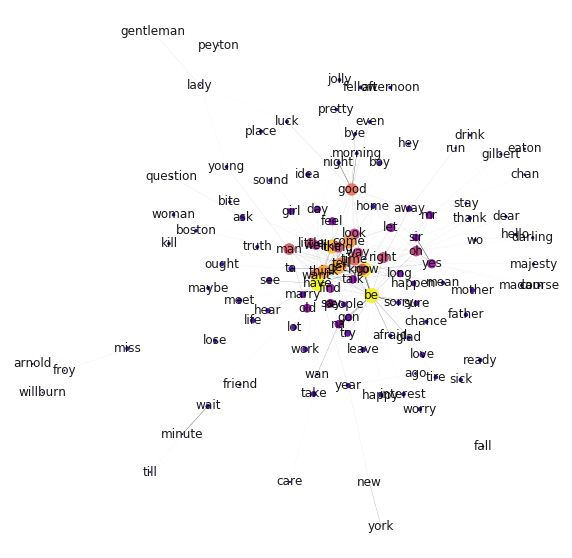

In [64]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities_1940_1960.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_1940_1960.edges(data = True)))
nx.draw(giant_1940_1960, ax = ax, pos = layout, labels = {n:n for n in giant_1940_1960.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_1940_1960.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_1940_1960[n] / maxC for n in giant_1940_1960.nodes],
        node_size = [centralities_1940_1960[n] / maxC * 200 for n in giant_1940_1960.nodes],
        cmap = plt.get_cmap('plasma'))

In [65]:
# top
sorted(centralities_1940_1960.items(), key = lambda x: x[1], reverse = True)[:10]

[('have', 0.307211516417183),
 ('be', 0.30219542492258306),
 ('know', 0.29431520449110044),
 ('like', 0.2624107057917611),
 ('get', 0.2516970944751268),
 ('think', 0.23829501319129257),
 ('come', 0.2309882580687806),
 ('tell', 0.21446547449259676),
 ('want', 0.2010013017001321),
 ('good', 0.19733150485735956)]

In [66]:
# look at POS based networks
import spacy
nlp = spacy.load('en')

In [67]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [68]:
gNN_1940_1960 = posCooccurrence(movie_df_1940_1960_n75['normalized_sents'].sum(), 'NN')

In [69]:
print(nx.info(gNN_1940_1960))

Name: 
Type: Graph
Number of nodes: 5258
Number of edges: 25769
Average degree:   9.8018


In [70]:
# this is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:
gNN_1940_1960.remove_nodes_from([n for n in gNN_1940_1960.nodes if len(set(gNN_1940_1960.neighbors(n))) <= 100]) 
print(nx.info(gNN_1940_1960))

Name: 
Type: Graph
Number of nodes: 70
Number of edges: 1277
Average degree:  36.4857


In [71]:
# And low weight edges:
gNN_1940_1960.remove_edges_from([(n1, n2) for n1, n2, d in gNN_1940_1960.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN_1940_1960))

Name: 
Type: Graph
Number of nodes: 70
Number of edges: 366
Average degree:  10.4571


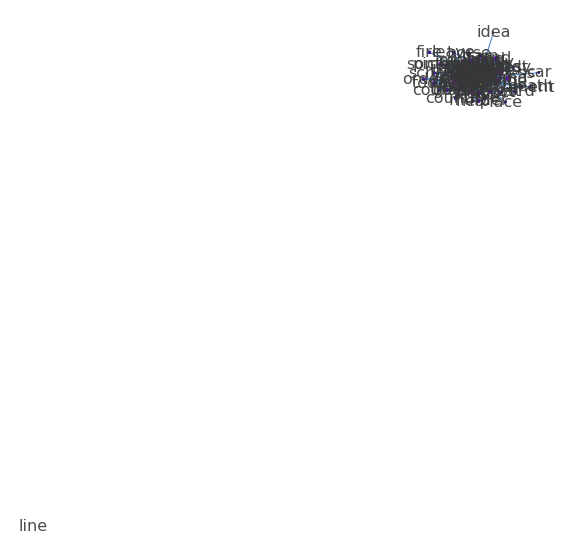

In [72]:
# visualize
layout_nn = nx.spring_layout(gNN_1940_1960, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN_1940_1960)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN_1940_1960.edges(data = True)))
nx.draw(gNN_1940_1960, ax = ax, pos = layout_nn, labels = {n: n for n in gNN_1940_1960.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN_1940_1960.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN_1940_1960.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [73]:
# What if we want to look at noun-verb pairs instead?
gNV_1940_1960 = posCooccurrence(movie_df_1940_1960_n75['normalized_sents'].sum(), 'NN', 'VB')

In [74]:
# gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:
print(nx.info(gNV_1940_1960))

Name: 
Type: Graph
Number of nodes: 5602
Number of edges: 46995
Average degree:  16.7779


In [75]:
gNV_1940_1960.remove_edges_from([(n1,n2) for n1,n2,d in gNV_1940_1960.edges(data = True) if gNV_1940_1960.nodes[n1]['bipartite'] == gNV_1940_1960.nodes[n2]['bipartite']])

In [76]:
print(nx.info(gNV_1940_1960))

Name: 
Type: Graph
Number of nodes: 5602
Number of edges: 19666
Average degree:   7.0211


In [77]:
# Dropping low weight edges and low degree vertices gives us:
gNV_1940_1960.remove_edges_from([(n1, n2) for n1, n2, d in gNV_1940_1960.edges(data = True) if d['weight'] <= 2])
gNV_1940_1960.remove_nodes_from([n for n in gNV_1940_1960.nodes if len(set(gNV_1940_1960.neighbors(n))) <= 5])

In [78]:
print(nx.info(gNV_1940_1960))

Name: 
Type: Graph
Number of nodes: 152
Number of edges: 1233
Average degree:  16.2237


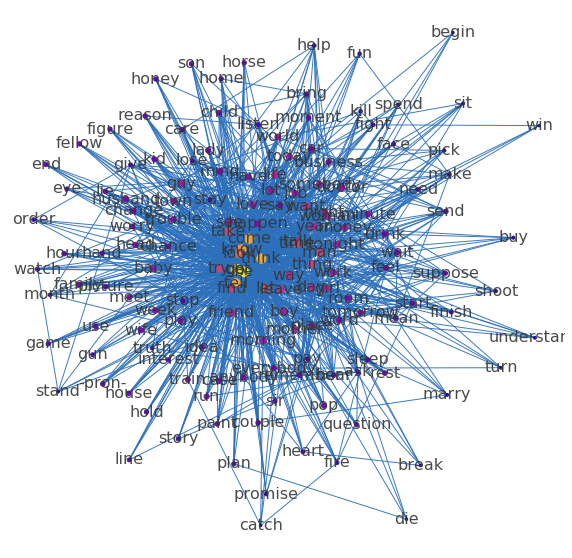

In [79]:
layout_nn = nx.spring_layout(gNV_1940_1960, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV_1940_1960,max_iter=500)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_1940_1960.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_1940_1960.edges(data = True)))
nx.draw(gNV_1940_1960, ax = ax, pos = layout_nn, labels = {n: n for n in gNV_1940_1960.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV_1940_1960.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV_1940_1960.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [80]:
# create an "ego network" surrounding a single (important) word, as we did before:
g_i_1940_1960 = gNV_1940_1960.subgraph(['die'] + list(gNV_1940_1960.neighbors('die')))

In [81]:
print(nx.info(g_i_1940_1960))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 4
Average degree:   1.6000


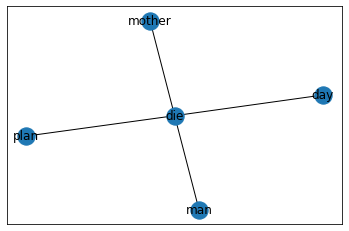

In [82]:
nx.draw_networkx(g_i_1940_1960)

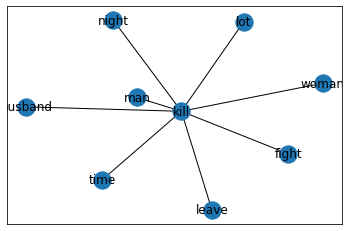

In [87]:
g_i_1940_1960 = gNV_1940_1960.subgraph(['kill'] + list(gNV_1940_1960.neighbors('kill')))
nx.draw_networkx(g_i_1940_1960)

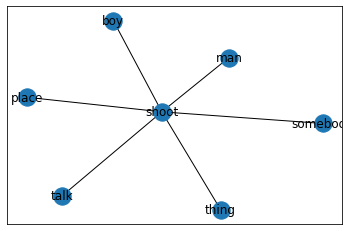

In [89]:
g_i_1940_1960 = gNV_1940_1960.subgraph(['shoot'] + list(gNV_1940_1960.neighbors('shoot')))
nx.draw_networkx(g_i_1940_1960)

In [83]:
gNJ_1940_1960 = posCooccurrence(movie_df_1940_1960_n75['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_1940_1960))

Name: 
Type: Graph
Number of nodes: 6798
Number of edges: 47715
Average degree:  14.0380


In [84]:
# can now filter our network by a centrality measure. Let's define a function and experiment with it:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [85]:
gNJ_filtered200_1940_1960 = filterWords(gNJ_1940_1960, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200_1940_1960))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 169
Average degree:  13.5200


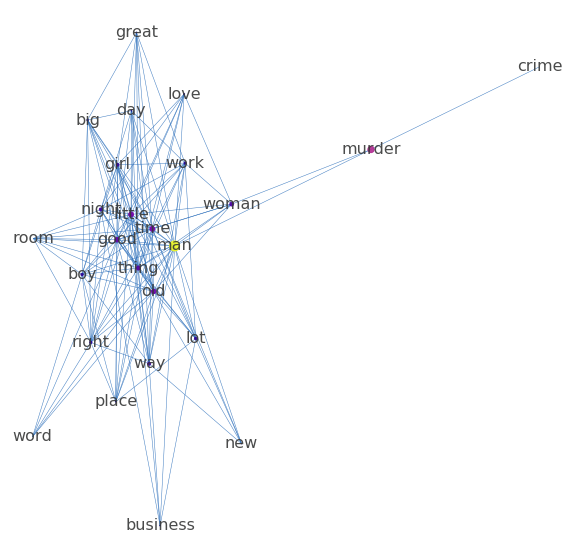

In [86]:
layout_NJ_filtered200_1940_1960 = nx.spring_layout(gNJ_filtered200_1940_1960, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200_1940_1960)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200_1940_1960, ax = ax, pos = layout_NJ_filtered200_1940_1960, labels = {n: n for n in gNJ_filtered200_1940_1960.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200_1940_1960.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200_1940_1960.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )